In [1]:
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.preprocessing import StandardScaler
from datetime import timedelta
from tqdm.auto import tqdm
from MLP import MLP
from LSTM import LSTM
from util.StockDataset import StockDataset, StockDatasetSequence
from torch.utils.data import DataLoader

In [2]:
import torch
import torch.nn as nn
import torch.optim

In [3]:
import pandas as pd
import yfinance as yf
from yahoofinancials import YahooFinancials

In [4]:
import os
import glob

In [5]:
# set style of graphs
plt.style.use('ggplot')
from pylab import rcParams
plt.rcParams['figure.dpi'] = 100

In [6]:
df = pd.read_csv('../../stock/AAPL.csv', parse_dates=True, index_col='Date').dropna(how="any")
X_train, X_test = train_test_split(df, test_size=0.02, shuffle=False)

In [8]:
train_dl = StockDataset(X_train)
dataloader = DataLoader(train_dl, batch_size=16, num_workers=4, shuffle=False)
batch_iter = enumerate(dataloader)

for batch_ndx, batch_tup in batch_iter:
        x = batch_tup[0]
        y = batch_tup[1]

1479


In [9]:
predictor = MLP()
predictor.fit(X_train, batch_size=16, epochs=10)

  0%|          | 0/10 [00:00<?, ?it/s]

torch.Size([16, 1]) torch.Size([16, 1])
torch.Size([16, 1]) torch.Size([16, 1])
torch.Size([16, 1]) torch.Size([16, 1])
torch.Size([16, 1]) torch.Size([16, 1])
torch.Size([16, 1]) torch.Size([16, 1])
torch.Size([16, 1]) torch.Size([16, 1])
torch.Size([16, 1]) torch.Size([16, 1])
torch.Size([16, 1]) torch.Size([16, 1])
torch.Size([16, 1]) torch.Size([16, 1])
torch.Size([16, 1]) torch.Size([16, 1])
torch.Size([16, 1]) torch.Size([16, 1])
torch.Size([16, 1]) torch.Size([16, 1])
torch.Size([16, 1]) torch.Size([16, 1])
torch.Size([16, 1]) torch.Size([16, 1])
torch.Size([16, 1]) torch.Size([16, 1])
torch.Size([16, 1]) torch.Size([16, 1])
torch.Size([16, 1]) torch.Size([16, 1])
torch.Size([16, 1]) torch.Size([16, 1])
torch.Size([16, 1]) torch.Size([16, 1])
torch.Size([16, 1]) torch.Size([16, 1])
torch.Size([16, 1]) torch.Size([16, 1])
torch.Size([16, 1]) torch.Size([16, 1])
torch.Size([16, 1]) torch.Size([16, 1])
torch.Size([16, 1]) torch.Size([16, 1])
torch.Size([16, 1]) torch.Size([16, 1])


In [10]:
predictor = MLP()
predictor.fit(X_train, batch_size=16, epochs=10)

  0%|          | 0/10 [00:00<?, ?it/s]

torch.Size([16, 1]) torch.Size([16, 1])
torch.Size([16, 1]) torch.Size([16, 1])
torch.Size([16, 1]) torch.Size([16, 1])
torch.Size([16, 1]) torch.Size([16, 1])
torch.Size([16, 1]) torch.Size([16, 1])
torch.Size([16, 1]) torch.Size([16, 1])
torch.Size([16, 1]) torch.Size([16, 1])
torch.Size([16, 1]) torch.Size([16, 1])
torch.Size([16, 1]) torch.Size([16, 1])
torch.Size([16, 1]) torch.Size([16, 1])
torch.Size([16, 1]) torch.Size([16, 1])
torch.Size([16, 1]) torch.Size([16, 1])
torch.Size([16, 1]) torch.Size([16, 1])
torch.Size([16, 1]) torch.Size([16, 1])
torch.Size([16, 1]) torch.Size([16, 1])
torch.Size([16, 1]) torch.Size([16, 1])
torch.Size([16, 1]) torch.Size([16, 1])
torch.Size([16, 1]) torch.Size([16, 1])
torch.Size([16, 1]) torch.Size([16, 1])
torch.Size([16, 1]) torch.Size([16, 1])
torch.Size([16, 1]) torch.Size([16, 1])
torch.Size([16, 1]) torch.Size([16, 1])
torch.Size([16, 1]) torch.Size([16, 1])
torch.Size([16, 1]) torch.Size([16, 1])
torch.Size([16, 1]) torch.Size([16, 1])


In [11]:
y_pred = predictor.predict(X_test)

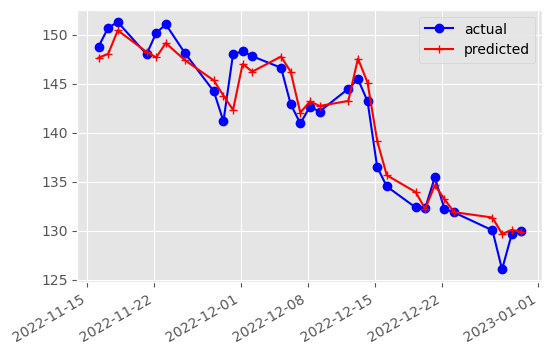

In [12]:
y_test = (X_test['Close']).values 
days = np.array(X_test.index, dtype="datetime64[ms]")
            
fig = plt.figure()
            
axes = fig.add_subplot(111)
axes.plot(days, y_test, 'bo-', label="actual") 
axes.plot(days, y_pred, 'r+-', label="predicted")
            
fig.autofmt_xdate()
            
plt.legend()
plt.show()